
# Задание 1: Задача бандитов и разведка/эксплуатация

This notebook will:
Этот ноутбук:
- Поможет вам создать свой первый алгоритм бандита
- Поможет вам понять влияние эпсилон на разведку и узнать о компромиссе между разведкой и эксплуатацией.
- Introduce you to some of the reinforcement learning software we are going to use for this specialization
- Познакомит вас с некоторым программным обеспечением для обучения с подкреплением

This class uses RL-Glue to implement most of our experiments. It was originally designed by Adam White, Brian Tanner, and Rich Sutton. This library will give you a solid framework to understand how reinforcement learning experiments work and how to run your own. If it feels a little confusing at first, don't worry - we are going to walk you through it slowly and introduce you to more and more parts as you progress through the specialization.

Этот класс использует RL-Glue для проведения большинства наших экспериментов. Первоначально он был разработан Адамом Уайтом, Брайаном Таннером и Ричем Саттоном. Эта библиотека даст вам прочную основу для понимания того, как работают эксперименты с обучением с подкреплением и как проводить свои собственные. Если поначалу она немного сбивает с толку, не стоит волноваться - мы постепенно познакомим вас со все большим и большим количеством ее частей по мере прохождения курса.

Мы предполагаем, что вы раньше использовали ноутбук Jupyter. Но если нет, то все довольно просто. Просто нажмите кнопку **run** или *Shift + Enter*, чтобы запустить каждую из ячеек. Места в коде, которые вам нужно заполнить, будут ясно обозначены.

## Раздел 0: Подготовка

In [21]:
 #Импорт необходимых библиотек

!wget https://github.com/andrew-veriga/DL/raw/master/assign.zip
!unzip -u assign.zip 
!rm assign.zip 

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

from rlglue.rl_glue import RLGlue
import main_agent
import ten_arm_env
import test_env

--2020-11-18 23:00:24--  https://github.com/andrew-veriga/DL/raw/master/assign.zip
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/andrew-veriga/DL/master/assign.zip [following]
--2020-11-18 23:00:24--  https://raw.githubusercontent.com/andrew-veriga/DL/master/assign.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6294 (6.1K) [application/zip]
Saving to: ‘assign.zip’

assign.zip          100%[===================>]   6.15K  --.-KB/s    in 0s      

2020-11-18 23:00:24 (37.5 MB/s) - ‘assign.zip’ saved [6294/6294]

Archive:  assign.zip


В ячейке выше мы импортируем библиотеки, которые нам нужны для этого задания. Мы используем numpy на протяжении всего курса и иногда даем подсказки, какие методы использовать из numpy. Кроме этого, мы в основном используем Vanilla Python и иногда другую библиотеку, такую ​​как matplotlib, для построения графиков.

Вы могли заметить, что мы импортируем ten_arm_env. Это __10-рукий стенд__, представленный в [разделе 2.3](http://www.incompleteideas.net/book/RLbook2018.pdf)  учебника. Мы используем его на протяжении всего этого ноутбука для тестирования наших бандитских агентов. У него есть 10 рук - это действия которые может выполнять агент. Выполнение такого действия генерирует стохастическое вознаграждение из распределения Гаусса с единичной дисперсией. Для каждого действия ожидаемая ценность этого действия выбирается случайным образом из нормального распределения перед каждым запуском. Если вы не знакомы с 10-руким стендом, просмотрите его в учебнике, прежде чем продолжить.

## Раздел 1: Жадный агент

Мы создадим агента, который будет искать действие с самой высокой ожидаемой наградой. Один из способов, которым может действовать агент - всегда выбирать действие с наибольшей ценностьбю на основе текущих оценок агента. Он называется жадным агентом, поскольку жадно выбирает действие, которое, по его мнению, имеет наибольшую ценность. Посмотрим, что происходит в этом случае.

Сначала мы реализуем функцию argmax, которая принимает список ценностей действий и возвращает действие с наибольшей ценностью. Почему мы реализуем нашу собственную, а не используем функцию argmax из библиотеки numpy? Функция argmax из numpy возвращает первое вхождение наибольшего значения. Нам не надо, чтобы так проиходило, поскольку так агент будет выбирать конкретное действие в случае наличия равных наград. Вместо этого мы хотим случайным образом выбирать между самыми высокими значениями. Итак, мы собираемся реализовать нашу собственную функцию argmax. Вы можете посмотреть [np.random.choice] (https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.choice.html), о случайном выборе из списка значений.

In [22]:
def argmax(q_values):
    """
    Принимает список q_values ​​и возвращает индекс элемента
    с наибольшим значением. Разрывает связи случайным образом.
    
    возвращает: int - индекс самого высокого значения в q_values
    """
    top_value = float("-inf")
    ties = []
    
    for i in range(len(q_values)):
        if q_values[i]>top_value:
            top_value = q_values[i]
            ties = []
        if q_values[i]==top_value:
            ties.append(i)
    return np.random.choice(ties)

In [23]:
# --------------
# Отладочная ячейка
# --------------

test_array = [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
assert argmax(test_array) == 8, "Check your argmax implementation returns the index of the largest value"

# убедитесь, что np.random.choice вызвана корректно
np.random.seed(0)
test_array = [1, 0, 0, 1]

assert argmax(test_array) == 0

In [24]:
# -----------
# Тестовая ячейка
# -----------

test_array = [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
assert argmax(test_array) == 8, "Check your argmax implementation returns the index of the largest value"

# Установить случайное начальное число, чтобы результаты были детерминированными
np.random.seed(0)
test_array = [1, 0, 0, 1]

counts = [0, 0, 0, 0]
for _ in range(100):
    a = argmax(test_array)
    counts[a] += 1

# убедиться, что argmax не всегда выбирает первое вхождение
assert counts[0] != 100, "Make sure your argmax implementation randomly choooses among the largest values."

# убедиться, что argmax не всегда выбирает последнее вхождение
assert counts[3] != 100, "Make sure your argmax implementation randomly choooses among the largest values."

# убедиться, что генератор случайных чисел вызван только один раз когда бы  `argmax` ни вызывался
expected = [44, 0, 0, 56] # <-- обратите внимание: не однородный из-за случайности
assert counts == expected

Теперь мы представляем первую часть агента RL-Glue, который вы будете реализовывать. Здесь мы создадим GreedyAgent и реализуем метод agent_step. Этот метод вызывается каждый раз, когда агент делает шаг. Метод должен возвращать действие, выбранное агентом. Этот метод также обеспечивает обновление оценок агента на основе сигналов, которые он получает из среды.

Заполните пропуски в коде, чтобы реализовать жадного агента.

In [25]:

class GreedyAgent(main_agent.Agent):
    def agent_step(self, reward, observation):
        """
        Один шаг агента. Входные параметры: награда, наблюдения
        возвращает действие, которое агент выбирает на этом временном шаге.
        
        Аргументы:
        reward -- float, награда, которую агент получил от окружения после выполнения последнего действия.
        observation -- float, наблюдаемое состояние, в котором находится агент. 
        Не беспокойтесь об этом, так как вы не будете его использовать до будущих уроков
        Возвращаемое значение:
        current_action -- int, действие, выбранное агентом на текущем временном шаге.
        """
        ### Переменные класса ###
        # self.q_values : Массив, содержащий, по мнению агента, все ценности действий (рук).
        # self.arm_count : Массив со счетчиком количества опускания каждой руки
        # self.last_action : Действие, которое агент совершил на предыдущем временном шаге.
        #######################
        
        # Update Q values Обновление значения Q 
        # Подсказка: посмотрите алгоритм в разделе "Инкрементная реализация" лекции "Многорукий бандит"
        # увеличить счетчик в self.arm_count для действия с предыдущего шага времени
        # обновление размера шага с использованием self.arm_count
        # обновление self.q_values для действия с предыдущего шага времени
        
        # ВАШ КОД ЗДЕСЬ
        current_action = argmax(self.q_values)
        #print(current_action)
        
        # текущее действие = ? # Используйте функцию argmax которую вы создали ранее
        # ВАШ КОД ЗДЕСЬ
        self.arm_count[self.last_action]+=1
        step_size = 1/self.arm_count[self.last_action]
        self.q_values[self.last_action] = self.q_values[self.last_action] + step_size*(reward-self.q_values[self.last_action])
        
    
        self.last_action = current_action
        
        return current_action

In [26]:
# --------------
# Отладочная ячейка
# --------------

# создать фейкового агента для тестирования и установить некоторые начальные условия
np.random.seed(1)
greedy_agent = GreedyAgent()
greedy_agent.q_values = [0, 0, 0.5, 0, 0]
greedy_agent.arm_count = [0, 1, 0, 0, 0]
greedy_agent.last_action = 1

action = greedy_agent.agent_step(reward=1, observation=0)

# убедиться, что q_values обновилась корректно
assert greedy_agent.q_values == [0, 0.5, 0.5, 0, 0]

# убедиться, что argmax выбирает равные наибольшие значения случайным образом
assert action == 2

In [27]:
# -----------
# Тестовая ячейка
# -----------

# Построение фейкового агента для проверки и установки некоторых начальных условий
greedy_agent = GreedyAgent()
greedy_agent.q_values = [0, 0, 1.0, 0, 0]
greedy_agent.arm_count = [0, 1, 0, 0, 0]
greedy_agent.last_action = 1

# tагент выполняет шаг
action = greedy_agent.agent_step(reward=1, observation=0)

# убедиться, что агент выбирает действие жадно
assert action == 2

# убедиться, что q_values было обновлено корректно
assert greedy_agent.q_values == [0, 0.5, 1.0, 0, 0]

Визуализируем результат. Здесь мы проведем эксперимент с использованием RL-Glue для тестирования нашего агента. Для начала мы настроим код эксперимента; в будущих уроках вы будете делать это самостоятельно.

100%|██████████| 200/200 [00:03<00:00, 54.74it/s]


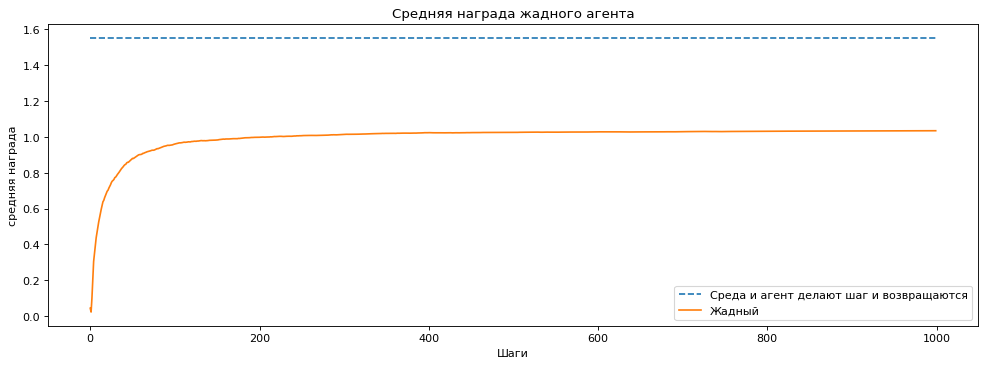

In [28]:

# ---------------
# Дискуссионная ячейка
# ---------------

num_runs = 200                    # количество запусков эксперимента
num_steps = 1000                  # Сколько раз агентом выбрана каждая рука
env = ten_arm_env.Environment     # Устанавливаем, какую среду мы хотим использовать для тестирования
agent = GreedyAgent               # Выбираем, какого агента мы хотим использовать
agent_info = {"num_actions": 10}  # Передаем агенту необходимую информацию. (Здесь - сколько всего рук).
env_info = {}                     # Передаем среде необходимую информацию. (В этом случае - ничего не передаем)

all_averages = []

average_best = 0
for run in tqdm(range(num_runs)):           # tqdm - создает индикатор выполнения
    np.random.seed(run)
    
    rl_glue = RLGlue(env, agent)          # Создает новый эксперимент RLGlue с окружением и агентом, которые мы выбрали выше.
    rl_glue.rl_init(agent_info, env_info) # передаем RLGlue все, что нужно для инициализации агента и среды.
    rl_glue.rl_start()                    # запускаем эксперимент

    average_best += np.max(rl_glue.environment.arms)
    
    scores = [0]
    averages = []
    
    for i in range(num_steps):
        reward, _, action, _ = rl_glue.rl_step() # Среда и агент делают шаг и возвращают
                                                 # награду и выбранное действие.
        scores.append(scores[-1] + reward)
        averages.append(scores[-1] / (i + 1))
    all_averages.append(averages)

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot([average_best / num_runs for _ in range(num_steps)], linestyle="--")
plt.plot(np.mean(all_averages, axis=0))
plt.legend(["Среда и агент делают шаг и возвращаются", "Жадный"])
plt.title("Средняя награда жадного агента")
plt.xlabel("Шаги")
plt.ylabel("средняя награда")
plt.show()
greedy_scores = np.mean(all_averages, axis=0)

Как дела у нашего агента? Можно ли сделать лучше?

## Раздел 2: Epsilon-жадный агент


Мы узнали о другом способ работы агента(раздел "компромисс разведка-эксплуатация" в лекции "Многорукий бандит"), где он не всегда проявляет жадность. Вместо этого иногда требуется исследовательское действие. Он делает это для того, чтобы узнать, какое действие на самом деле лучше всего. Если мы всегда выбираем только то, что, по нашему мнению, является лучшим действием на данный момент, мы можем упустить возможность выбрать действительно лучшее действие, потому что мы не узнавали какие еще бывают действия, или, другими словами, не делали разведку.

Реализация epsilon-greedy agent ниже. Мы реализуем алгоритм из раздела "Инкрементная реализация". Вы можете использовать свой жадный код сверху и посмотреть в [np.random.random](https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.random.html), а так же [np.random.randint](https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.randint.html), для помощи в случайном выборе действия. 

In [29]:

class EpsilonGreedyAgent(main_agent.Agent):
    def agent_step(self, reward, observation):
        """
        Takes one step for the agent. It takes in a reward and observation and 
        returns the action the agent chooses at that time step.
        
        Arguments:
        reward -- float, the reward the agent recieved from the environment after taking the last action.
        observation -- float, the observed state the agent is in. Do not worry about this as you will not use it
                              until future lessons
        Returns:
        current_action -- int, the action chosen by the agent at the current time step.
        """
        
        ### Useful Class Variables ###
        # self.q_values : Массив, содержащий, по мнению агента, ценности каждой руки.
        # self.arm_count : Массив с подсчетом количества выбора каждой руки.
        # self.last_action : Действие, которое агент предпринял на предыдущем шаге времени.
        # self.epsilon : Вероятность того, что эпсилон-жадный агент  будет разведывать (колеблется от 0 до 1)
        #######################
        
        # Обновление ценностей Q - это должно быть то же обновление, что и у вашего жадного агента выше
        # ВАШ КОД ЗДЕСЬ
        random = np.random.random((1,1))
        if random<self.epsilon:
            current_action = np.random.randint(len(self.q_values))
        else:
            current_action = argmax(self.q_values)
        
        # Выбрать действие, используя эпсилон-жадность
        # Случайно выбрать число от 0 до 1 и посмотреть, не меньше ли оно, чем self.epsilon
        # (подсказка: загляните в np.random.random()). Если это так, установите для current_action случайное действие.
        # в противном случае жадно выбирайте current_action, как делали выше.
        # ВАШ КОД ЗДЕСЬ
        self.arm_count[self.last_action]+=1
        step_size = 1/self.arm_count[self.last_action]
        self.q_values[self.last_action] = self.q_values[self.last_action] + step_size*(reward-self.q_values[self.last_action])
        
        
        self.last_action = current_action
        
        return current_action

        
    
        
      

In [30]:
# --------------
# Отладочная ячейка
# --------------

# сделать фейкового агента для тестирования и установки некоторых начальных ограничений
np.random.seed(0)
e_greedy_agent = EpsilonGreedyAgent()
e_greedy_agent.q_values = [0, 0.0, 0.5, 0, 0]
e_greedy_agent.arm_count = [0, 1, 0, 0, 0]
e_greedy_agent.num_actions = 5
e_greedy_agent.last_action = 1
e_greedy_agent.epsilon = 0.5

# учитывая random.seed, мы должны увидеть здесь жадное действие (действие 2)
action = e_greedy_agent.agent_step(reward=1, observation=0)

# -----------------------------------------------
# попробуем угадать несколько более сложных мест
# -----------------------------------------------

# убедиться, что обновляете *last_action*, а не текущее действие
assert e_greedy_agent.q_values != [0, 0.5, 1.0, 0, 0], "A"

# убедиться, что stepsize основывается на *last_action* а не на текущем действии
assert e_greedy_agent.q_values != [0, 1, 0.5, 0, 0], "B"

# убедитесь, что агент использует argmax, который выбирает максимальные случайным образом
assert action == 2, "C"

# -----------------------------------------------

# посмотрим, что произойдет с другим действием
np.random.seed(1)
e_greedy_agent = EpsilonGreedyAgent()
e_greedy_agent.q_values = [0, 0.5, 0.5, 0, 0]
e_greedy_agent.arm_count = [0, 1, 0, 0, 0]
e_greedy_agent.num_actions = 5
e_greedy_agent.last_action = 1
e_greedy_agent.epsilon = 0.5

# учитывая этот random.seed, мы должны увидеть здесь случайное действие (действие 4)
action = e_greedy_agent.agent_step(reward=1, observation=0)

# Агент увидел награду 1, поэтому следует увеличить значение для *last_action*
assert e_greedy_agent.q_values == [0, 0.75, 0.5, 0, 0], "D"

# агент должен был выбрать случайное действие для этого конкретного случайного числа
assert action == 4, "E"

In [31]:
# -----------
# Тестовая ячейка
# -----------

np.random.seed(0)
e_greedy_agent = EpsilonGreedyAgent()
e_greedy_agent.q_values = [0, 0, 1.0, 0, 0]
e_greedy_agent.arm_count = [0, 1, 0, 0, 0]
e_greedy_agent.num_actions = 5
e_greedy_agent.last_action = 1
e_greedy_agent.epsilon = 0.5
action = e_greedy_agent.agent_step(reward=1, observation=0)

assert e_greedy_agent.q_values == [0, 0.5, 1.0, 0, 0]

# манипулировать random.seed, чтобы агент выполнял случайное действие
np.random.seed(1)
action = e_greedy_agent.agent_step(reward=0, observation=0)

assert action == 4

# убедиться, что ценность действия 4 обновилась
action = e_greedy_agent.agent_step(reward=1, observation=0)
assert e_greedy_agent.q_values == [0, 0.5, 0.0, 0, 1.0]

Now that we have our epsilon greedy agent created. Let's compare it against the greedy agent with epsilon of 0.1.

100%|██████████| 200/200 [00:07<00:00, 26.84it/s]


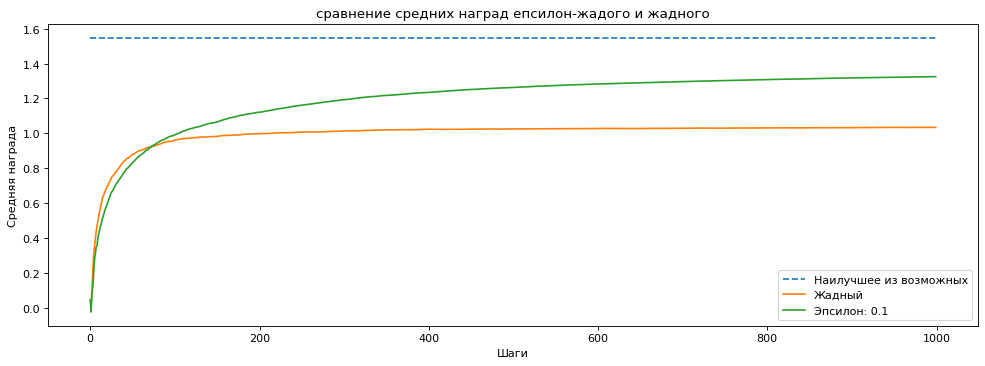

In [32]:
# ---------------
# Дискуссионная ячейка
# ---------------

# Рисует результаты Epsilon-жадных и жадных
num_runs = 200
num_steps = 1000
epsilon = 0.1
agent = EpsilonGreedyAgent
env = ten_arm_env.Environment
agent_info = {"num_actions": 10, "epsilon": epsilon}
env_info = {}
all_averages = []

for run in tqdm(range(num_runs)):
    np.random.seed(run)
    
    rl_glue = RLGlue(env, agent)
    rl_glue.rl_init(agent_info, env_info)
    rl_glue.rl_start()

    scores = [0]
    averages = []
    for i in range(num_steps):
        reward, _, action, _ = rl_glue.rl_step() # Среда и агент делают шаг и возвращают
                                                 # награду и выбранное действие.
        scores.append(scores[-1] + reward)
        averages.append(scores[-1] / (i + 1))
    all_averages.append(averages)

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot([1.55 for _ in range(num_steps)], linestyle="--")
plt.plot(greedy_scores)
plt.title("сравнение средних наград епсилон-жадого и жадного")
plt.plot(np.mean(all_averages, axis=0))
plt.legend(("Наилучшее из возможных", "Жадный", "Эпсилон: 0.1"))
plt.xlabel("Шаги")
plt.ylabel("Средняя награда")
plt.show()

Обратите внимание, насколько лучше работает эпсилон-жадный агент. Поскольку мы время от времени выбираем случайное действие, мы смогли найти лучшую долгосрочную политику. Действуя жадно до того, как наши оценки ценности станут точными, мы рискуем выбрать неоптимальные действия.

## Раздел 2.1 Усреднение многократных запусков

Вы заметили, что мы набрали в среднем более 2000 прогонов? Почему мы это сделали?

Чтобы получить некоторое представление, давайте посмотрим на результаты двух отдельных запусков одного и того же агента.

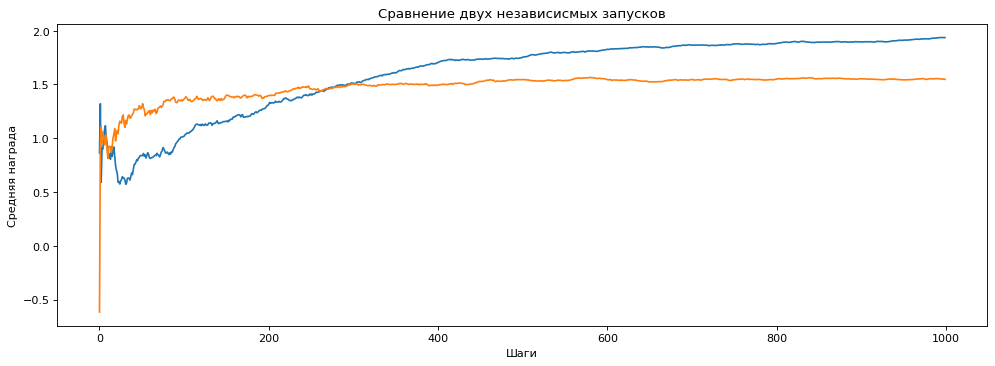

In [33]:
# ---------------
# Дискуссионная ячейка
# ---------------

# график запусков e-greedy агента
agent = EpsilonGreedyAgent
env = ten_arm_env.Environment
agent_info = {"num_actions": 10, "epsilon": 0.1}
env_info = {}
all_averages = []
plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
num_steps = 1000

for run in (0, 1):
    np.random.seed(run) # Здесь мы устанавливаем seed, чтобы сравнить два разных запуска
    averages = []
    rl_glue = RLGlue(env, agent)
    rl_glue.rl_init(agent_info, env_info)
    rl_glue.rl_start()

    scores = [0]
    for i in range(num_steps):
        reward, state, action, is_terminal = rl_glue.rl_step()
        scores.append(scores[-1] + reward)
        averages.append(scores[-1] / (i + 1))
    
    plt.plot(averages)

plt.title("Сравнение двух независисмых запусков")
plt.xlabel("Шаги")
plt.ylabel("Средняя награда")
plt.show()

Обратите внимание, как отличаются эти два запуска. Но если это один и тот же алгоритм, почему он по-разному ведет себя в этих двух прогонах?

Ответ в том, что это происходит из-за случайностей в среде и агенте. В зависимости от того, с какого случайного действия начинает агент или когда он случайным образом выбирает разведку, изменяются результаты запусков. И даже если агент выбирает то же действие, награда из среды случайным образом выбирается из гауссианы. Агенту может повезти, и он получит большие награды за лучшее действие на ранней стадии и, таким образом, быстрее выберет лучшее действие. Или ему может не повезти и он получит меньшие награды за лучшее действие на раннем этапе, и поэтому потребуется больше времени, чтобы понять, что это на самом деле лучшее действие.

Чтобы быть более конкретным, давайте посмотрим, сколько раз выполняется разведка для разных seeds.

In [34]:
# ---------------
# Дискуссионная ячейка
# ---------------
print("Random Seed 1")
np.random.seed(1)
for _ in range(15):
    if np.random.random() < 0.1:
        print("Разведка")
    

print()
print()

print("Random Seed 2")
np.random.seed(2)
for _ in range(15):
    if np.random.random() < 0.1:
        print("Разведка")

Random Seed 1
Разведка
Разведка
Разведка


Random Seed 2
Разведка


С первым seed мы разведываем три раза из 15, но со вторым мы разведываем только один раз. Это может существенно повлиять на производительность нашего агента, потому что количество разведок, во время которых награды выбираются  неоптимально, значительно отличается.

Поэтому для сравнения алгоритмов мы выводим производительность, усредненную по многим запускам. Мы делаем это, чтобы гарантировать, что мы не просто выводим результат, связанный со стохастичностью. Скорее, нам нужны статистически значимые результаты. В этом курсе мы не будем использовать тесты статистической значимости. Вместо этого, поскольку у нас есть доступ к симуляторам для наших экспериментов, мы используем более простую стратегию выполнения большого количества запусков и обеспечим, чтобы доверительные интервалы не перекрывались.

## Раздел 3: Сравение значений для епсилон

Можем ли мы сделать лучше, чем epsilon=0,1? Давайте попробуем несколько разных значений epsilon и посмотрим, как они работают. Мы попробуем разные настройки ключевых параметров производительности, чтобы понять, как агент может работать в разных условиях.

Ниже мы проводим эксперимент, в котором мы перебираем разные значения для epsilon:

100%|██████████| 200/200 [00:07<00:00, 27.60it/s]


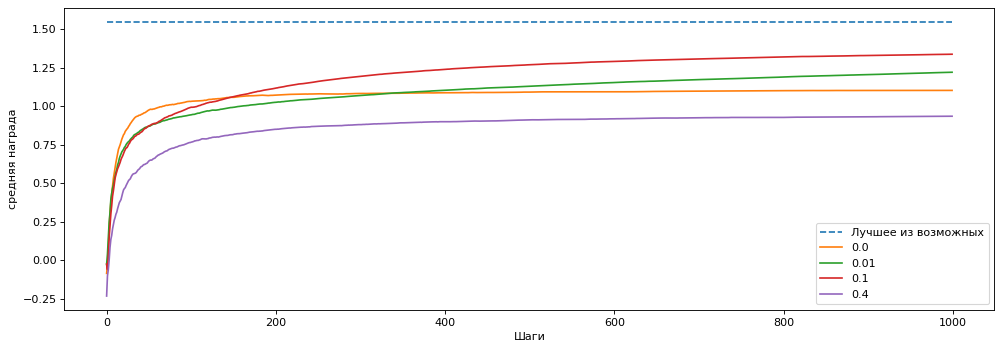

In [35]:
# ---------------
# Дискуссионная ячейка
# ---------------

# Эксперимент для разных e-greedy
epsilons = [0.0, 0.01, 0.1, 0.4]

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot([1.55 for _ in range(num_steps)], linestyle="--")

n_q_values = []
n_averages = []
n_best_actions = []

num_runs = 200

for epsilon in epsilons:
    all_averages = []
    for run in tqdm(range(num_runs)):
        agent = EpsilonGreedyAgent
        agent_info = {"num_actions": 10, "epsilon": epsilon}
        env_info = {"random_seed": run}

        rl_glue = RLGlue(env, agent)
        rl_glue.rl_init(agent_info, env_info)
        rl_glue.rl_start()
        
        best_arm = np.argmax(rl_glue.environment.arms)

        scores = [0]
        averages = []
        best_action_chosen = []
        
        for i in range(num_steps):
            reward, state, action, is_terminal = rl_glue.rl_step()
            scores.append(scores[-1] + reward)
            averages.append(scores[-1] / (i + 1))
            if action == best_arm:
                best_action_chosen.append(1)
            else:
                best_action_chosen.append(0)
            if epsilon == 0.1 and run == 0:
                n_q_values.append(np.copy(rl_glue.agent.q_values))
        if epsilon == 0.1:
            n_averages.append(averages)
            n_best_actions.append(best_action_chosen)
        all_averages.append(averages)
        
    plt.plot(np.mean(all_averages, axis=0))

plt.legend(["Лучшее из возможных"] + epsilons)
plt.xlabel("Шаги")
plt.ylabel("средняя награда")
plt.show()

Почему 0,1 оказался лучше 0,01?

Если разведка помогает, почему 0,4 работает хуже, чем 0,0 (жадный агент)?

Подумайте, как бы вы ответили на эти вопросы. Это вопросы были в тесте. Если у вас все еще есть вопросы, повторите тест.

## Раздел 4: влияние размера шага

В Разделе 1 этого задания мы уменьшали размер шага с течением времени на основе подсчета выбора действий. Размер шага был $\frac{1}{N(A)}$ , где N(A) - сколько раз было выбрано действие A. Это то же самое, что и вычисление среднего по выборке. Мы также можем сделать размер шага постоянным, например 0,1. Каков будет эффект от этого? И что лучше: метод постоянного или среднего по выборке?

Чтобы исследовать этот вопрос, давайте начнем с создания нового агента с постоянным размером шага. Он будет почти идентичен агенту, созданному выше. Вы будете использовать тот же код для epsilon-жадного выбора действия. Вы измените обновление на постоянный размер шага вместо использования обновления $\frac{1}{N(A)}$.

In [37]:


class EpsilonGreedyAgentConstantStepsize(main_agent.Agent):
    def agent_step(self, reward, observation):
        """
        Делает один шаг за агента. Получает награду и разведку и
         возвращает действие, которое агент выбирает на этом шаге времени.
        
        Аргументы:
         reward - float, награда, полученная агентом от окружения после выполнения последнего действия.
         observation - float, наблюдаемое состояние, в котором находится агент. Не беспокойтесь об этом, так как вы не будете его использовать
                               до будущих уроков
        Возврат:
         current_action - int, действие, выбранное агентом на текущем временном шаге.
        """
        
        ### Useful Class Variables ###
        # self.q_values: массив, содержащий, по мнению агента, ценности каждой руки.
        # self.arm_count: массив со счетчиком количества выбора каждой руки.
        # self.last_action: int, действие, которое агент выполнил на предыдущем временном шаге.
        # self.step_size: float, текущий размер шага агента.
        # self.epsilon: вероятность разведки эпсилон-жадного агента(от 0 до 1)
        #######################
        
        # Обновить q_values для действий, предпринятых на предыдущем временном шаге
        # используя self.step_size вместо self.arm_count
        # ВАШ КОД ЗДЕСЬ
        random = np.random.random((1,1))
        if random<self.epsilon:
            current_action = np.random.randint(len(self.q_values))
        else:
            current_action = argmax(self.q_values)
        
        # Выберите действие с эпсилон-жадным. Это то же самое, что вы реализовали выше.
        # ВАШ КОД ЗДЕСЬ
        self.q_values[self.last_action] = self.q_values[self.last_action] + self.step_size*(reward-self.q_values[self.last_action])
        
        self.last_action = current_action
        
        return current_action

In [38]:
# --------------
# Отладочная ячейка
# --------------

for step_size in [0.01, 0.1, 0.5, 1.0]:
    e_greedy_agent = EpsilonGreedyAgentConstantStepsize()
    e_greedy_agent.q_values = [0, 0, 1.0, 0, 0]
    e_greedy_agent.num_actions = 5
    e_greedy_agent.last_action = 1
    e_greedy_agent.epsilon = 0.0
    e_greedy_agent.step_size = step_size
    action = e_greedy_agent.agent_step(1, 0)
    assert e_greedy_agent.q_values == [0, step_size, 1.0, 0, 0], "Убедитесь, что вы правильно обновляете q_values, используя размер шага."

In [39]:
# -----------
# Тестовая ячейка
# -----------

np.random.seed(0)
# Проверить Epsilon Greedy с разными постоянными размерами шага
for step_size in [0.01, 0.1, 0.5, 1.0]:
    e_greedy_agent = EpsilonGreedyAgentConstantStepsize()
    e_greedy_agent.q_values = [0, 0, 1.0, 0, 0]
    e_greedy_agent.num_actions = 5
    e_greedy_agent.last_action = 1
    e_greedy_agent.epsilon = 0.0
    e_greedy_agent.step_size = step_size
    
    action = e_greedy_agent.agent_step(1, 0)
    
    assert e_greedy_agent.q_values == [0, step_size, 1.0, 0, 0]

100%|██████████| 200/200 [00:07<00:00, 26.41it/s]


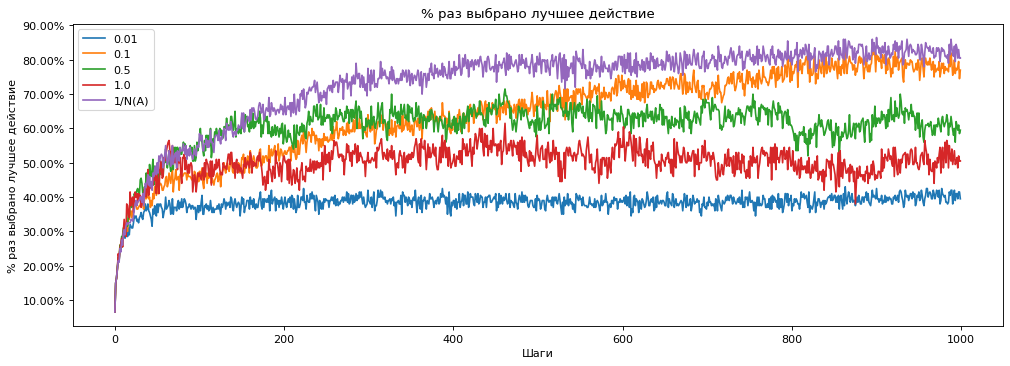

In [40]:
# ---------------
# Дискуссионная ячейка
# ---------------

# Эксперимент для разных размеров шага
step_sizes = [0.01, 0.1, 0.5, 1.0, '1/N(A)']

epsilon = 0.1
num_steps = 1000
num_runs = 200

fig, ax = plt.subplots(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')

q_values = {step_size: [] for step_size in step_sizes}
true_values = {step_size: None for step_size in step_sizes}
best_actions = {step_size: [] for step_size in step_sizes}

for step_size in step_sizes:
    all_averages = []
    for run in tqdm(range(num_runs)):
        np.random.seed(run)
        agent = EpsilonGreedyAgentConstantStepsize if step_size != '1/N(A)' else EpsilonGreedyAgent
        agent_info = {"num_actions": 10, "epsilon": epsilon, "step_size": step_size, "initial_value": 0.0}
        env_info = {}

        rl_glue = RLGlue(env, agent)
        rl_glue.rl_init(agent_info, env_info)
        rl_glue.rl_start()
        
        best_arm = np.argmax(rl_glue.environment.arms)

        scores = [0]
        averages = []
        
        if run == 0:
            true_values[step_size] = np.copy(rl_glue.environment.arms)
            
        best_action_chosen = []
        for i in range(num_steps):
            reward, state, action, is_terminal = rl_glue.rl_step()
            scores.append(scores[-1] + reward)
            averages.append(scores[-1] / (i + 1))
            if action == best_arm:
                best_action_chosen.append(1)
            else:
                best_action_chosen.append(0)
            if run == 0:
                q_values[step_size].append(np.copy(rl_glue.agent.q_values))
        best_actions[step_size].append(best_action_chosen)
    ax.plot(np.mean(best_actions[step_size], axis=0))

plt.legend(step_sizes)
plt.title("% раз выбрано лучшее действие")
plt.xlabel("Шаги")
plt.ylabel("% раз выбрано лучшее действие")
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])
plt.show()


Во-первых, обратите внимание, что теперь мы выводим время, за  которое предпринимается лучшее действие, а не среднюю награду. Чтобы лучше понять производительность агента, может быть полезно измерить конкретное поведение, помимо накопленного вознаграждения. Этот показатель показывает, насколько поведение агента близко к оптимальному.

It seems as though 1/N(A) performed better than the others, in that it reaches a solution where it takes the best action most frequently. Now why might this be? Why did a step size of 0.5 start out better but end up performing worse? Why did a step size of 0.01 perform so poorly?
Кажется, что $\frac{1}{N(A)}$ работает лучше, чем другие, в том смысле, что он достигает решения, при котором наиболее часто выбирается лучшее действие. Почему бы это могло быть? Почему размер шага 0,5 вначале лучше, но в итоге он работает хуже? Почему размер шага 0,01 так плохо работает?


Давайте разберемся в этом. Посмотрим, насколько хорошо каждый агент следует за истинной ценностью, где у каждого агента есть свой метод размера шага. Вам не нужно здесь программировать, просто следуйте инструкциям.

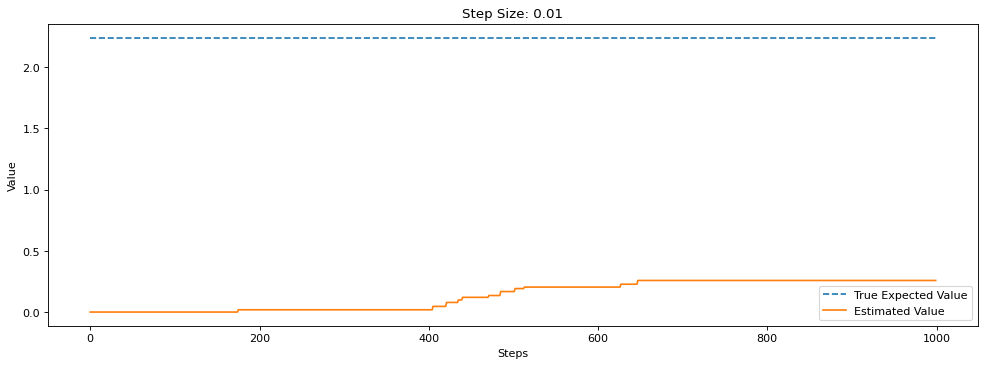

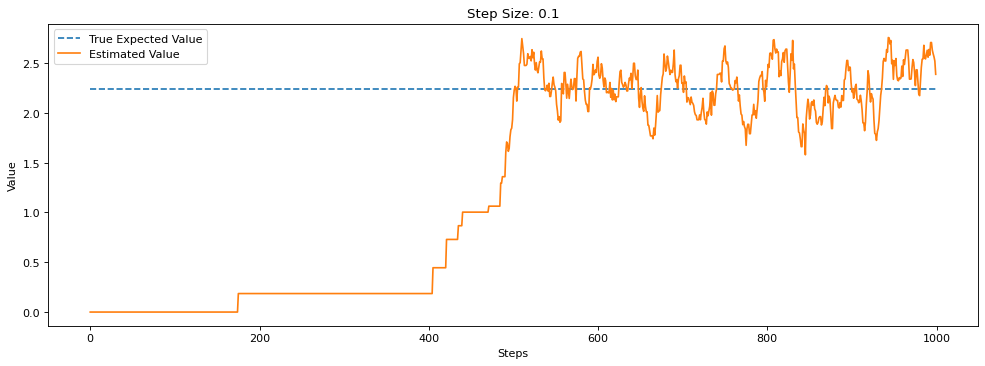

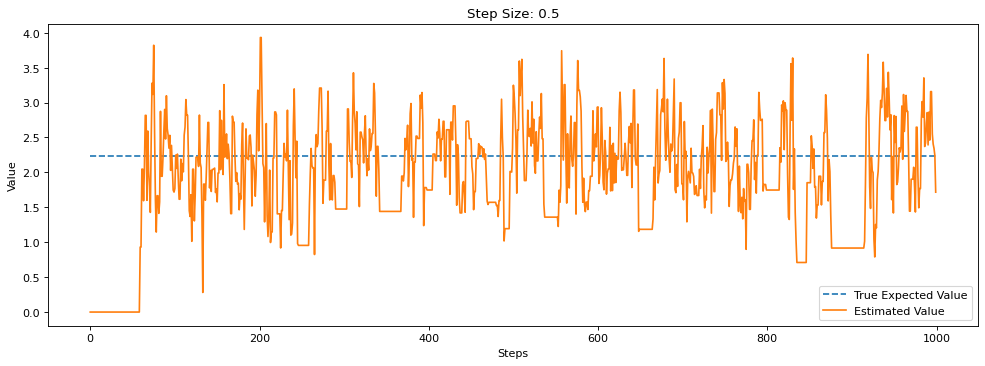

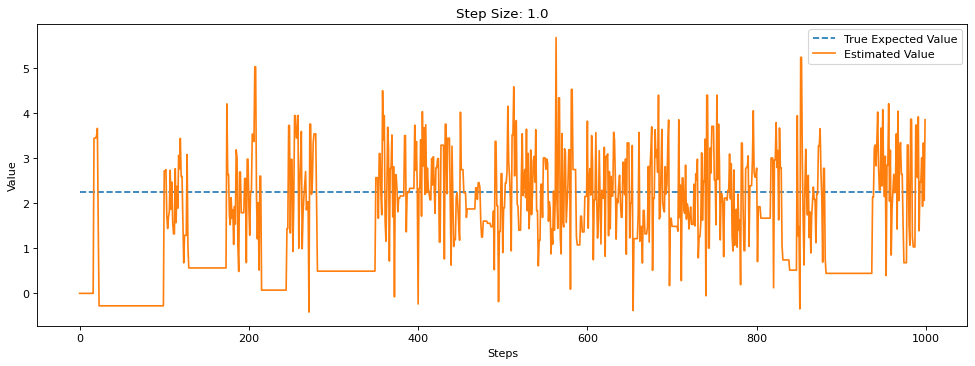

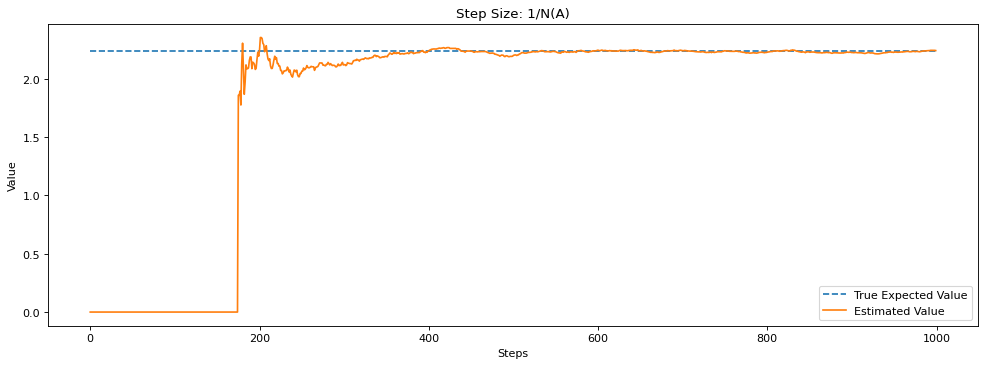

In [41]:
# lock
# ---------------
# Discussion Cell
# ---------------
largest = 0
num_steps = 1000
for step_size in step_sizes:
    plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
    largest = np.argmax(true_values[step_size])
    plt.plot([true_values[step_size][largest] for _ in range(num_steps)], linestyle="--")
    plt.title("Step Size: {}".format(step_size))
    plt.plot(np.array(q_values[step_size])[:, largest])
    plt.legend(["True Expected Value", "Estimated Value"])
    plt.xlabel("Steps")
    plt.ylabel("Value")
    plt.show()

Эти графики помогают выяснить различия в производительности между шагами разных размеров. 
- Размер шага 0,01 приводит к таким небольшим обновлениям, что оценка агентом наилучшего действия не приближается к фактическому значению. 
- Размер шага 0,5 и 1,0 быстро приближаются к нужной ценности, но они очень чувствительны к стохастичности наград. Обновления слишком сильно корректируют недавние награды и колеблются вокруг истинной ценности. 

Это означает, что на многих этапах жадное действие может выглядеть хуже, чем оно есть. Размер шага 0,1 довольно быстро обновляется до истинного значения и не так сильно колеблется вокруг истинных ценностей, как 0,5 и 1,0. Это одна из причин того, что 0.1 работает достаточно хорошо. 

Наконец, мы видим, почему 1/N(A) показало себя хорошо. Вначале, когда размер шага все еще достаточно высок, он быстро приближается к истинному ожидаемому значению, но по мере увеличения N, размер шага уменьшается, что делает его менее восприимчивым к стохастичности вознаграждения.


Означает ли это, что 1/N(A) всегда лучший метод? Когда это может быть не так?
Одна из возможных ситуаций, когда шаг $\frac{1}{N(A)}$ может оказаться неэффективным, - это нестационарные задачи. Вы слышали о нестационарности в лекциях. Нестационарность означает, что окружающая среда может со временем меняться. Это может проявляться как постоянное изменение окружающей среды с течением времени или внезапное изменение окружающей среды.

Давайте посмотрим, как внезапное изменение в распределении вознаграждения влияет на размер шага 1/N(A). На этот раз мы запустим среду для 2000 шагов, а после 1000 шагов мы случайным образом изменим ожидаемое значение для всех рук. Мы сравниваем двух агентов, оба использующих epsilon-жадность с epsilon = 0.1. Один использует _постоянный размер шага_ 0.1, другой - _изменяемый размер шага_ 1/N(A).

100%|██████████| 200/200 [00:14<00:00, 13.36it/s]


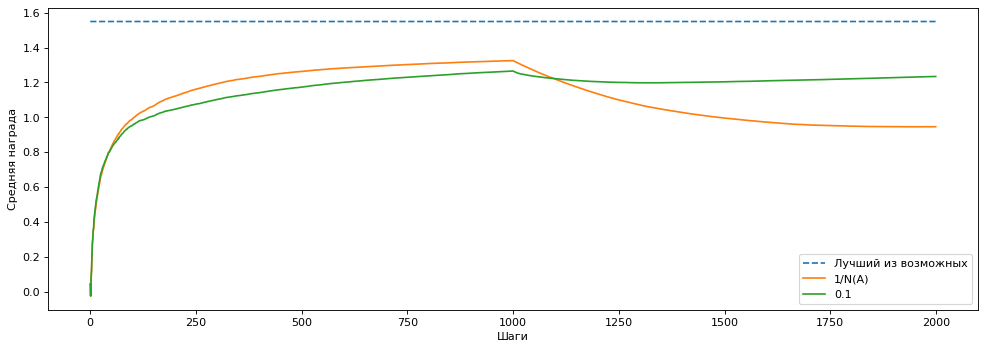

In [42]:

# ---------------
# Дискуссионная ячейка
# ---------------
epsilon = 0.1
num_steps = 2000
num_runs = 200
step_size = 0.1

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot([1.55 for _ in range(num_steps)], linestyle="--")

for agent in [EpsilonGreedyAgent, EpsilonGreedyAgentConstantStepsize]:
    all_averages = []
    for run in tqdm(range(num_runs)):
        agent_info = {"num_actions": 10, "epsilon": epsilon, "step_size": step_size}
        np.random.seed(run)
        
        rl_glue = RLGlue(env, agent)
        rl_glue.rl_init(agent_info, env_info)
        rl_glue.rl_start()

        scores = [0]
        averages = []
        
        for i in range(num_steps):
            reward, state, action, is_terminal = rl_glue.rl_step()
            scores.append(scores[-1] + reward)
            averages.append(scores[-1] / (i + 1))
            if i == 1000:
                rl_glue.environment.arms = np.random.randn(10)
        all_averages.append(averages)
        
    plt.plot(np.mean(all_averages, axis=0))
plt.legend(["Лучший из возможных", "1/N(A)", "0.1"])
plt.xlabel("Шаги")
plt.ylabel("Средняя награда")
plt.show()

Теперь агент с размером шага 1 / N (A) работал лучше в начале, но затем работал хуже при изменении среды! Что случилось?

Подумайте, какой будет размер шага после 1000 шагов. Скажем, лучшее действие выбирается 500 раз. Это означает, что размер шага для этого действия составляет 1/500 или 0,002. На каждом шаге, когда мы обновляем значение действия, и значение будет перемещаться только на 0,002 * ошибка. Это очень маленькая корректировка, и потребуется много времени, чтобы она достигла истинной ценности.

В то же время агент с размером шага 0,1 всегда обновляется на одну десятую в направлении ошибки. Это означает, что в среднем потребуется десять шагов, чтобы обновить свое значение до среднего по выборке.


Это те типы компромиссов, о которых мы должны думать при обучении с подкреплением. Чем больше размер шага, тем быстрее мы приближаемся к истинной ценности, но наши расчетные ценности могут колебаться вокруг ожидаемой ценности. Размер шага, который уменьшается со временем, может приближаться к ожидаемому ценности без колебаний. С другой стороны, такой уменьшающийся размер шага не может адаптироваться к изменениям в окружающей среде. Нестационарность - и связанная с ней концепция частичной наблюдаемости - является общей чертой задач обучения с подкреплением и обучения на ходу.

## Раздел 5: Заключение

Отлично! Итак, в этом практическом задании вы:
- реализовали своего первого агента
- узнали о влиянии епсилона, параметра разведки, на производительность агента
- узнали о влиянии размера шага на производительность агента